In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.types import Float, String, Integer, DateTime
from geoalchemy2 import Geometry
import requests
import json

# Database configuration
POSTGRES_USER = "user"
POSTGRES_PASSWORD = "password"
POSTGRES_DB = "urban_data"
POSTGRES_HOST = "postgres"
POSTGRES_PORT = "5432"

# Create a connection string
connection_string = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
engine = create_engine(connection_string)

# Load datasets
link_info_path = '/home/jovyan/work/data/link_info.parquet.gz'
speed_data_path = '/home/jovyan/work/data/duval_jan1_2024.parquet.gz'
link_info_url = 'https://cdn.urbansdk.com/data-engineering-interview/link_info.parquet.gz'
speed_data_url = 'https://cdn.urbansdk.com/data-engineering-interview/duval_jan1_2024.parquet.gz'

# Download dataset func
def download_file(url, local_path):
    response = requests.get(url)
    response.raise_for_status() 
    with open(local_path, 'wb') as file:
        file.write(response.content)

# Fazer o download dos arquivos
download_file(link_info_url, link_info_path)
download_file(speed_data_url, speed_data_path)

link_info_df = pd.read_parquet(link_info_path)
speed_data_df = pd.read_parquet(speed_data_path)

In [2]:
# Define functions to transform data for insertion
def transform_link_info(df):
    # Ensure geo_json is a valid geometry type for PostGIS
    df['geometry'] = df['geo_json'].apply(lambda x: json.dumps(x) if isinstance(x, dict) else x)
    return df.drop(columns=['geo_json'])  # Drop the geo_json column after transformation

def transform_speed_data(df):
    # Ensure date_time is in a DateTime format
    df['date_time'] = pd.to_datetime(df['date_time'])
    return df

# Transform the datasets
link_info_df = transform_link_info(link_info_df)
speed_data_df = transform_speed_data(speed_data_df)

In [3]:
# Insert data into the existing tables
def insert_data(df, table_name):
    df.to_sql(table_name, engine, if_exists="append", index=False)

# Insert data with transformations applied
insert_data(link_info_df, "link_info")
insert_data(speed_data_df, "speed_data")

print("Data inserted successfully.")

Data inserted successfully.


In [4]:
# Load data into DataFrames
link_info_df = pd.read_sql_table("link_info", engine)
speed_data_df = pd.read_sql_table("speed_data", engine)

# Check the first few rows and data types
print("Link Info Data:")
display(link_info_df.head())
print("Speed Data:")
display(speed_data_df.head())

# Summary statistics
print("Summary Statistics - Link Info Data:")
display(link_info_df.describe())
print("Summary Statistics - Speed Data:")
display(speed_data_df.describe())

Link Info Data:


,link_id,_length,road_name,usdk_speed_category,funclass_id,speedcat,volume_value,volume_bin_id,volume_year,volumes_bin_description,geometry
0,1148855686,0.027340324,None,40,4,2,800,1,2022,0-1999,"{""type"":""MultiLineString"",""coordinates"":[[[-81..."
1,1240632857,0.019262501,E 21st St,40,4,5,5000,3,2022,5000-7449,"{""type"":""MultiLineString"",""coordinates"":[[[-81..."
2,1240632858,0.021126614,E 21st St,40,4,5,5000,3,2022,5000-7449,"{""type"":""MultiLineString"",""coordinates"":[[[-81..."
3,1240474884,0.037903631,University Blvd W,40,4,5,18000,6,2022,15000-19999,"{""type"":""MultiLineString"",""coordinates"":[[[-81..."
4,1240959781,0.022369356,None,40,4,5,3500,2,2022,2000-4999,"{""type"":""MultiLineString"",""coordinates"":[[[-81..."


Speed Data:


,link_id,date_time,freeflow,count,std_dev,min,max,confidence,average_speed,average_pct_85,average_pct_95,day_of_week,period
0,1295292965,2024-01-01 10:00:00+00:00,44.739,63,9.3,27.962,57.788,40,42.750,50.331,52.817,2,4
1,23058981,2024-01-01 20:00:00+00:00,49.710,27,12.2,41.010,67.729,40,52.630,64.001,67.729,2,7
2,1202899217,2024-01-01 15:00:00+00:00,34.797,13,15.5,8.078,41.632,40,31.100,42.253,45.671,2,5
3,1241183256,2024-01-01 13:00:00+00:00,13.670,6,4.8,8.078,16.777,40,13.359,16.777,16.777,2,5
4,835679519,2024-01-01 15:00:00+00:00,29.826,13,20.8,3.728,46.603,30,32.032,42.564,46.292,2,5


Summary Statistics - Link Info Data:


,link_id,usdk_speed_category,funclass_id,speedcat,volume_value,volume_bin_id,volume_year
count,2.018480e+05,201848.000000,201848.000000,201848.000000,201848.000000,201848.000000,201848.0
mean,7.663716e+08,34.331576,4.528467,5.537394,4144.457215,2.104088,2022.0
std,5.560587e+08,7.371550,0.796227,1.024512,7963.677599,1.909514,0.0
min,1.698105e+07,20.000000,1.000000,2.000000,100.000000,1.000000,2022.0
25%,2.305349e+07,30.000000,4.000000,5.000000,200.000000,1.000000,2022.0
50%,1.032972e+09,30.000000,5.000000,6.000000,400.000000,1.000000,2022.0
75%,1.293699e+09,40.000000,5.000000,6.000000,5000.000000,3.000000,2022.0
max,1.334783e+09,70.000000,5.000000,7.000000,60000.000000,9.000000,2022.0


Summary Statistics - Speed Data:


,link_id,freeflow,count,std_dev,min,max,confidence,average_speed,average_pct_85,average_pct_95,day_of_week,period
count,2.479892e+06,2.479892e+06,2.479892e+06,2.479892e+06,2.479892e+06,2.479892e+06,2.479892e+06,2.479892e+06,2.479892e+06,2.479892e+06,2479892.0,2.479892e+06
mean,8.811686e+08,3.118691e+01,3.041918e+01,9.096169e+00,2.183279e+01,4.147413e+01,3.186700e+01,3.240514e+01,3.823041e+01,4.019489e+01,2.0,4.352719e+00
std,5.045093e+08,1.427759e+01,8.093343e+01,6.754172e+00,1.469899e+01,2.109084e+01,1.023360e+01,1.636159e+01,1.798277e+01,1.934773e+01,0.0,2.092258e+00
min,1.698105e+07,4.970000e-01,1.000000e+00,0.000000e+00,6.210000e-01,6.210000e-01,1.000000e+01,6.210000e-01,6.210000e-01,6.210000e-01,2.0,1.000000e+00
25%,7.212930e+08,2.236900e+01,2.000000e+00,3.800000e+00,9.942000e+00,2.423300e+01,3.000000e+01,1.988400e+01,2.423300e+01,2.423300e+01,2.0,3.000000e+00
50%,1.188470e+09,2.982600e+01,6.000000e+00,8.900000e+00,1.988400e+01,4.163200e+01,4.000000e+01,3.206300e+01,3.914600e+01,4.101000e+01,2.0,5.000000e+00
75%,1.282162e+09,3.976800e+01,2.500000e+01,1.300000e+01,3.231100e+01,5.592300e+01,4.000000e+01,4.312300e+01,5.033100e+01,5.405900e+01,2.0,6.000000e+00
max,1.313710e+09,7.021500e+01,2.603000e+03,1.049000e+02,1.547210e+02,1.584500e+02,4.000000e+01,1.547210e+02,1.553430e+02,1.584500e+02,2.0,7.000000e+00


In [5]:
# Check for missing values
print("Missing values in Link Info Data:")
print(link_info_df.isnull().sum())
print("Missing values in Speed Data:")
print(speed_data_df.isnull().sum())


Missing values in Link Info Data:
link_id                        0
_length                        0
road_name                  21972
usdk_speed_category            0
funclass_id                    0
speedcat                       0
volume_value                   0
volume_bin_id                  0
volume_year                    0
volumes_bin_description        0
geometry                       0
dtype: int64
Missing values in Speed Data:
link_id           0
date_time         0
freeflow          0
count             0
std_dev           0
min               0
max               0
confidence        0
average_speed     0
average_pct_85    0
average_pct_95    0
day_of_week       0
period            0
dtype: int64


In [6]:
# Query to calculate average speed by link_id, period, and day of the week
query = """
SELECT
    s.link_id,
    AVG(s.average_speed) AS avg_speed,
    l.road_name,
    l._length AS length,
    l.geometry AS geo_json,
    s.period
FROM
    speed_data s
JOIN
    link_info l ON s.link_id = l.link_id
GROUP BY
    s.link_id, s.period, s.day_of_week, l.road_name, l._length, l.geometry
"""

# Fetch data into a DataFrame
transformed_df = pd.read_sql_query(query, engine)
transformed_df.head()

,link_id,avg_speed,road_name,length,geo_json,period
0,16981048,47.845500,Philips Hwy,0.009320565,"{""type"":""MultiLineString"",""coordinates"":[[[-81...",1
1,16981048,47.804333,Philips Hwy,0.009320565,"{""type"":""MultiLineString"",""coordinates"":[[[-81...",2
2,16981048,45.401333,Philips Hwy,0.009320565,"{""type"":""MultiLineString"",""coordinates"":[[[-81...",3
3,16981048,47.265333,Philips Hwy,0.009320565,"{""type"":""MultiLineString"",""coordinates"":[[[-81...",4
4,16981048,47.970000,Philips Hwy,0.009320565,"{""type"":""MultiLineString"",""coordinates"":[[[-81...",5


In [23]:
# Query to find  the names of the roads in a given bounding box
query = """
SELECT DISTINCT
    road_name,
    ST_AsText(geometry) AS geometry_text
FROM 
    link_info
WHERE 
    geometry && ST_MakeEnvelope(-81.7, 30.2, -81.5, 30.4, 4326)
AND
    road_name IS NOT "None";
"""
# Fetch data into a DataFrame
roads_df = pd.read_sql_query(query, engine)
roads_df.tail()


,road_name,geometry_text
40963,None,"MULTILINESTRING((-81.69935 30.23814,-81.69944 ..."
40964,None,"MULTILINESTRING((-81.69953 30.2258,-81.70029 3..."
40965,None,"MULTILINESTRING((-81.69999 30.21826,-81.70005 ..."
40966,None,"MULTILINESTRING((-81.70146 30.23437,-81.70134 ..."
40967,None,"MULTILINESTRING((-81.70164 30.31917,-81.70124 ..."


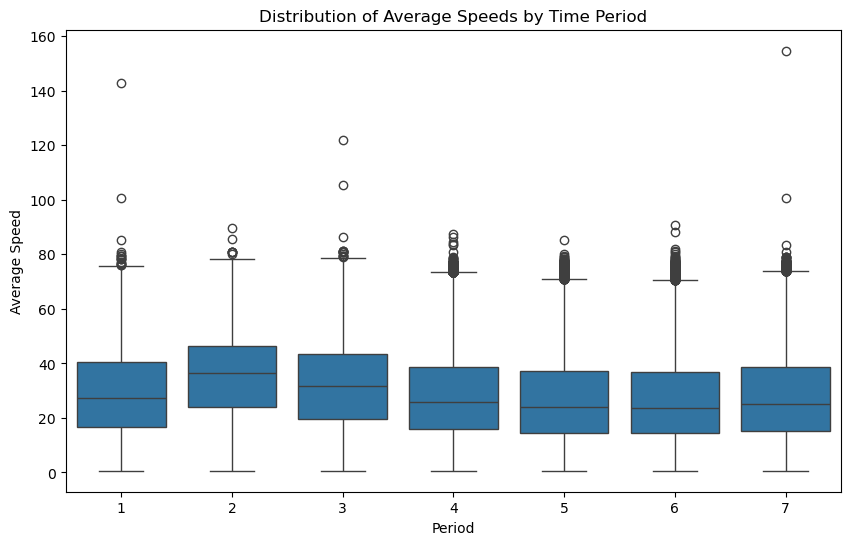

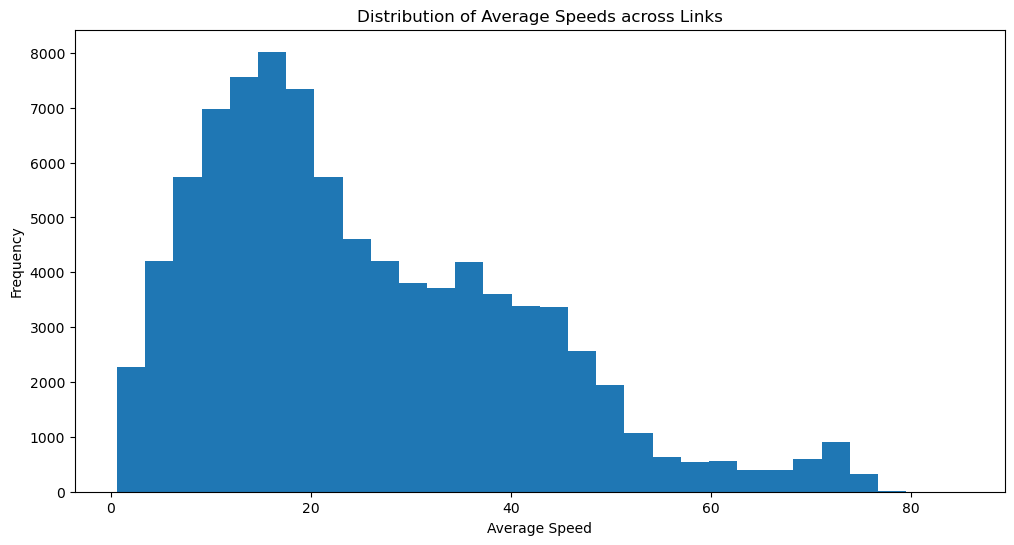

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Average speed by day of the week
plt.figure(figsize=(10, 6))
sns.boxplot(data=transformed_df, x="period", y="avg_speed")
plt.title("Distribution of Average Speeds by Time Period")
plt.xlabel("Period")
plt.ylabel("Average Speed")
plt.show()

# Average speed by link and period
avg_speed_by_link = transformed_df.groupby("link_id")["avg_speed"].mean()
plt.figure(figsize=(12, 6))
avg_speed_by_link.plot(kind="hist", bins=30)
plt.title("Distribution of Average Speeds across Links")
plt.xlabel("Average Speed")
plt.ylabel("Frequency")
plt.show()


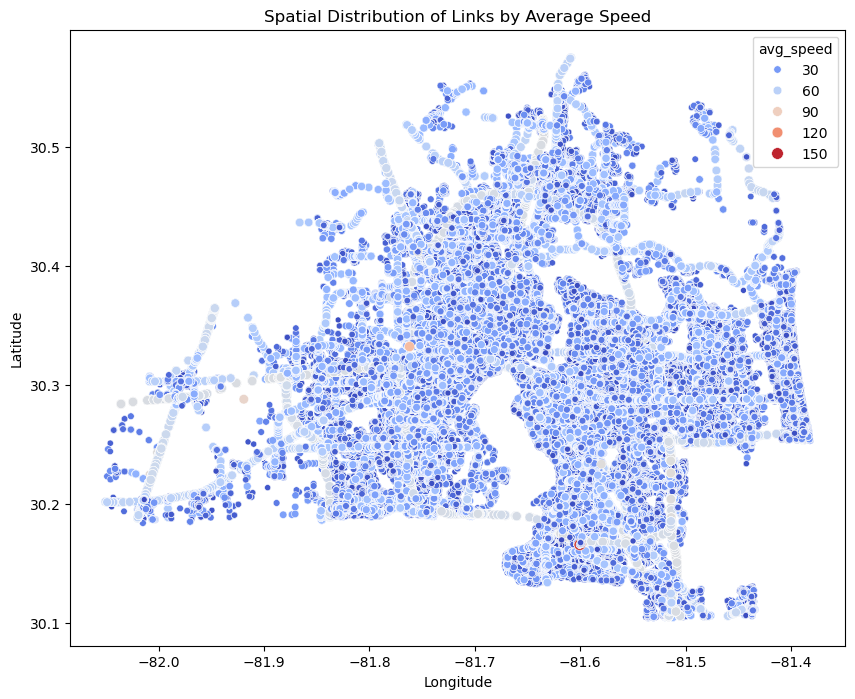

In [13]:
from shapely import wkb
import json
from shapely.geometry import shape

# Convert GeoJSON strings to Shapely geometries
transformed_df['geometry'] = transformed_df['geo_json'].apply(lambda x: shape(json.loads(x)) if x else None)

# Extract coordinates from Shapely geometries
# For MultiLineString geometries, we'll use the centroid for simplicity
transformed_df['coordinates'] = transformed_df['geometry'].apply(lambda geom: geom.centroid.coords[0] if geom else (None, None))

# Separate longitude and latitude
transformed_df['longitude'] = transformed_df['coordinates'].apply(lambda x: x[0])
transformed_df['latitude'] = transformed_df['coordinates'].apply(lambda x: x[1])

# Display the resulting DataFrame
transformed_df[['link_id', 'avg_speed', 'longitude', 'latitude']].head()

# Scatter plot of locations colored by average speed
plt.figure(figsize=(10, 8))
sns.scatterplot(data=transformed_df, x="longitude", y="latitude", hue="avg_speed", palette="coolwarm", size="avg_speed")
plt.title("Spatial Distribution of Links by Average Speed")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


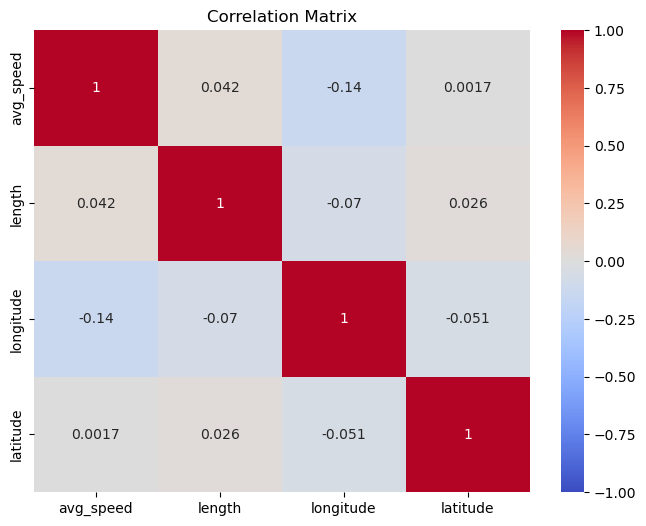

In [16]:
# Select numeric columns for correlation analysis
corr_features = transformed_df[['avg_speed', 'length', 'longitude', 'latitude']]
corr_matrix = corr_features.corr()

# Display correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features for modeling
X = transformed_df[['length', 'longitude', 'latitude', 'period']]
y = transformed_df['avg_speed']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Model evaluation
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))


Mean Squared Error: 258.96370855783897
R^2 Score: 0.031175029713136126


In [14]:
# Average speed by period
avg_speed_by_period = transformed_df.groupby('period')['avg_speed'].mean()
print(avg_speed_by_period)

period
1    29.021914
2    35.812333
3    32.273701
4    28.212232
5    26.842923
6    26.542830
7    27.614424
Name: avg_speed, dtype: float64


In [15]:
from mapboxgl.utils import create_color_stops
from mapboxgl.viz import ChoroplethViz
from IPython.display import IFrame
import json

# Mapbox token
mapbox_token = "pk.eyJ1IjoiZ3VpYm9ydG9sYXNvIiwiYSI6ImNtMndoajR4czA2d2sybXB0enNhc2dtcjAifQ.PHvelUdPZ4tW7WQL0fvNmQ"

# Convert DataFrame to GeoJSON
geojson_data = {
    "type": "FeatureCollection",
    "features": []
}

for _, row in transformed_df.iterrows():
    feature = {
        "type": "Feature",
        "geometry": row["geo_json"],  # Assuming geo_json is already in GeoJSON format
        "properties": {
            "link_id": row["link_id"],
            "avg_speed": row["avg_speed"],
            "road_name": row["road_name"],
            "length": row["length"]
        }
    }
    geojson_data["features"].append(feature)

# Define color stops for visualization
color_stops = create_color_stops([20, 40, 60, 80], colors=['blue', 'green', 'yellow', 'red'])

# Create the map visualization
viz = ChoroplethViz(
    geojson_data,
    access_token=mapbox_token,
    color_property="avg_speed",
    color_stops=color_stops,
    center=(-81.6556, 30.3322), 
    zoom=10,
    line_stroke="blue"
)

# Save the map visualization to HTML
viz.create_html('map_visualization.html')

# Display the HTML file in an IFrame
IFrame('map_visualization.html', width=700, height=500)
